# Analisy results MOA mini-batching with loop fusion

The results compareds this work use follow variables.

Frequencies in MHz:

    - Minimum: 600Mhz, Maximum: 1200Mhz

Size mini-batching uses are:

    - 25, 50, 75, 100, 250, 500, 200
    
The device utilized is Rasp PI 2 with CPU armv7l, 4 cores, model name Cortex-A53

All executions are used ensemble size 25.

## Observation

To batch size 5 and 15 had very problemas with null pointer execption to this optimization loop fusion because this not any experiment with size batch.

# Introdução

Neste notebook procuramos identificar os resultados obtidos em acuracia, precisão, revocação, JPI (Joules por instance) e IPS (Instancias por segundo) para a otimização de loop-fusion feita nos algoritmos do MOA (Adaptive Random Forest, OzaBag, LBag, OzaBagAHST e o Streaming Random Patches) cada um destes algoritmos tem certas especificidades para a classificação de dados e foram implementados a técnica de mini-batching. Neste notebook além da técnica de mini-batching utilizamos mais uma otimização de loop conhecida como loop fusion para otimizar o acesso a memória desta forma reduzindo o consumo enérgetico e também o tempo de processamento, mas procurando não piorar a classificação das instancias.

In [1239]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
%mkdir -p parsed_csvs figures
%cd results

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching
/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results


In [1240]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
pd.set_option('display.max_rows', 300)
pd.options.display.float_format = '{:,.2f}'.format

In [1241]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string

    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                ret_string += str(spline[c]) + ','
            ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

In [1242]:
def add_label_column_df(df):
    df = df.drop(df[df.batch_size == 5].index)
    df = df.drop(df[df.batch_size == 15].index)
    df = df.drop(df[df.batch_size == 25].index)
    df = df.drop(df[df.batch_size > 50].index)

    df.batch_size[df.batch_size == 1] = 'Sequential'
    df.batch_size[df.batch_size == 0] = 'MB'
    df.batch_size[df.batch_size == 50] = 'MB-LF'
    
    return df

In [1243]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    return select_columns_and_rename_values(df)

In [1244]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    df.batch_size.unique()
    return df

In [1245]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

In [1246]:
import natsort

#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg_order, markers):
    lwidth = 0.75
    if markers:
        colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    else:
        colors=['g', 'b', 'r', 'm', 'y' , 'k']

    labels = df.batch_size
    alg = df.algorithm.unique()[0]
    x = np.arange(len(labels))
    
    ax.plot(x, pd.to_numeric(df.prec), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg}-prec')
    ax.plot(x, pd.to_numeric(df.recall), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(50, 100)

In [1247]:
#iterates over the parameter configurations and creates the chart grid
def gen_chart(df, markers=True, tables=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    
    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    
    #creates a 2x2 grid for plotting the charts
    #sharey=row means that all charts in a row share the same Y-axis
    fig, axs = plt.subplots(2, 2, figsize=(12,12), sharey='row')
    filename = "batch-size-vs-prediction-mark" if markers else "batch-size-vs-prediction"
    #each chart presents the results for a given dataset and contains the series for all algorithms
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        #selects the correct position in the grid
        ax = axs[int(my_id/2)][my_id%2]
        ax.set_title(f'{dsformalname[ds]}')
        #for each algorithm
        for alg in algorithms:
            #filters the df to contain the wanted values
#             df_aux = filter_by_substring_algorithm(df[df.dataset == ds].sort_values(by=['batch_size']), alg)
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds], alg)
            #df_aux = df_aux.sort_values(by=['label'], ascending=True)
            #if tables:
                #display(df_aux)
            #plot (include) the series in the chart
            gen_lines(df_aux, ax, algorithms.index(alg), markers)
            #if its the first column, print Y-axis label
            if my_id%2 == 0:
                ax.set_ylabel('Percentage')
            #if its the last row, print the X-axis label
            if int(my_id/2) == 1:
                ax.set_xlabel('Algorithm Methodology')
    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [1248]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/loop-fusion/acc"
wantedCSVfilename = "data-batch-vs-acc-600-1200-first.csv"

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


In [1249]:
resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

df = load_df(f'{csvFile}')
df = add_label_column_df(df)

/Users/reginaldoluisdeluna/Library/Python/3.8/lib/python/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_9489/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_9489/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_9489/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequentia

# Classificação - Precisão e Revocação

Os dados apresentam resultados para sequencial sem o mini-batching e resultados para o mini-batching no tamanho 50 e mini-batching com loop fusion também com o batch de 50.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


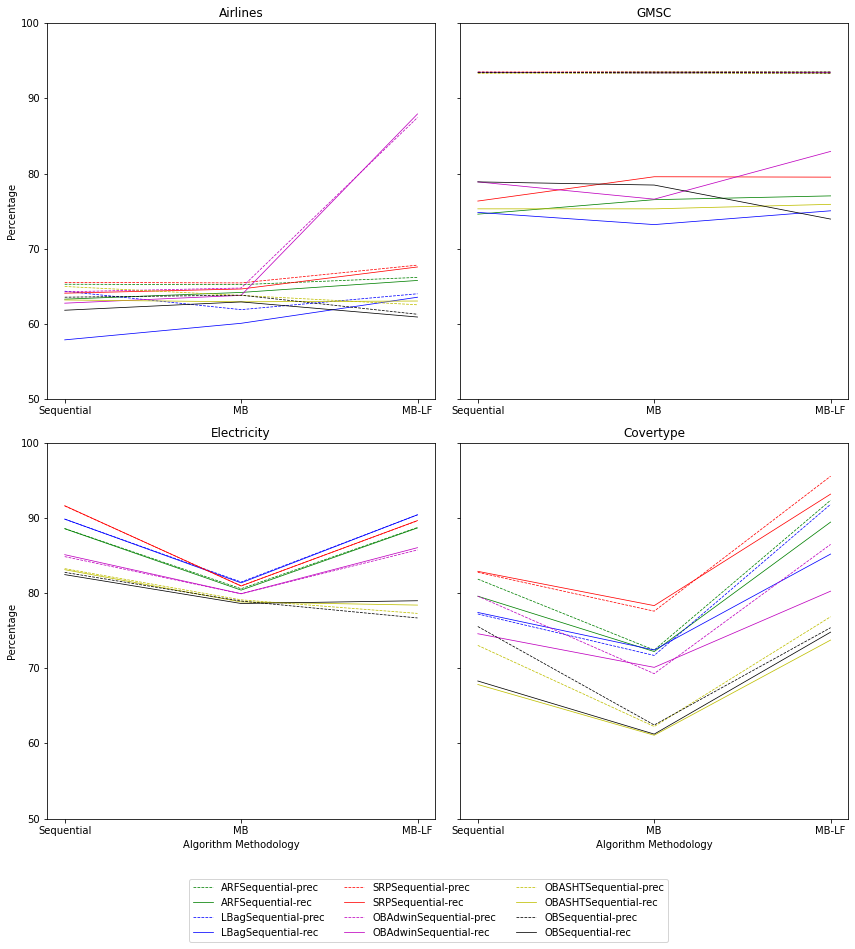

In [1250]:
#false makes the chart without markers
gen_chart(df.sort_values(by=['cores', 'batch_size'], ascending=True), False)

# Consumer Energy

In [1251]:
PATH_TO_RESULTS = '/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/loop-fusion/coletor-energia/15092022/'

In [1252]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)', 'classifications correct (percent)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','

    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,inc_rate,methodology,instances,time,delay,out_rate,acc'
            pstr = f"{head}\n{pstr}"
            header_printed = True

        return (pstr[:-1])

In [1253]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)

    df['inc_rate'].astype('int64')
    return df[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
                'methodology', 'instances', 'time', 'delay', 'out_rate', 'acc']]

# Read Energy Data

In [1254]:
def load_Wmeas(filename):
    return pd.read_csv(filename, header=None, names=['date', 'time', 'measure'])

In [1255]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        dataset = algorithm = Esize = cores = Bsize = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')
                if len(spline) == 6:
                    dataset,algorithm,Esize,cores,Bsize,rate,methodology = spline
                else:
                    dataset,algorithm,Esize,cores,Bsize,rate,methodology = spline
                if algorithm not in d:
                    d[algorithm] = {}
                if dataset not in d[algorithm]:
                    d[algorithm][dataset] = {}
                if Esize not in d[algorithm][dataset]:
                    d[algorithm][dataset][Esize] = {}
                if cores not in d[algorithm][dataset][Esize]:
                    d[algorithm][dataset][Esize][cores] = {}
                if Bsize not in d[algorithm][dataset][Esize][cores]:
                    d[algorithm][dataset][Esize][cores][Bsize] = {}
                if rate not in d[algorithm][dataset][Esize][cores][Bsize]:
                    d[algorithm][dataset][Esize][cores][Bsize][rate] = {'start': date_time_obj, 'finish': ''}
                    dnow = d[algorithm][dataset][Esize][cores][Bsize][rate]
                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
    return d

In [1256]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            for k2, v2 in v1.items():
                for k3, v3 in v2.items():
                    for k4, v4 in v3.items():
                        for k5, v5 in v4.items():
                            if 'seconds' not in v5:
                                st = v5['start']
                                ed = v5['finish']
                                v5['seconds'] = (ed - st).seconds
                                new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                                          & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
                                v5['avg_measure'] = new_df['measure'].mean()
                                v5['sum_measure'] = new_df['measure'].sum()
                                v5['avg_times_seconds'] = v5['avg_measure'] * v5['seconds']
    return d

In [1257]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 
               'sum_measure': [], 'avg_times_seconds': []}
    for kalg,valg in d.items():
        for kds,vds in valg.items():
            for kens,vens in vds.items():
                for kcore,vcore in vens.items():
                    for kmbs,vmbs in vcore.items():
                        for krate,vrate in vmbs.items():
                            dappend['algorithm'].append(kalg)
                            dappend['dataset'].append(kds)
                            dappend['ensemble_size'].append(kens)
                            dappend['cores'].append(kcore)
                            dappend['batch_size'].append(kmbs)
                            dappend['duration'].append(vrate['seconds'])
                            dappend['inc_rate'].append(krate)
                            for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                                dappend[key].append(vrate[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64',
                                                           'batch_size': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]

# Parse SSH Logs

In [1258]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'batch_size': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': [], 'methodology': []}
    with open (fname, "r") as file:
        for line in file:
            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
                    spline = line.split('-')

                    if "MAX" in line:
                        if len(spline[1:]) == 3:
                            dataset, alg, rate = spline[1:]
                            bsize = 500
                        else:
                            dataset, alg, bsize, rate, methodology = spline[1:]
                    else:
                        dataset, alg, bsize, rate, methodology = spline[1:]
                        bsize = 1
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
                    d['batch_size'].append(bsize)
                    d['methodology'].append(methodology.strip())
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False
    return pd.DataFrame.from_dict(d).astype({'inc_rate': 'int64'})

# Showing and preparing for charts

In [1259]:
def filter_fields(df):
    wanted = ['algorithm', 'dataset', 'batch_size', 'cores', 'out_rate', 'instances', 'delay', 'joules', 'JPI']
    return df[[
        l for l in df.columns if any([w in l for w in wanted])
    ]]

In [1260]:
def rename_columns_by_rate(df):
    rate = df.PERC.iloc[0]
    return df.rename(columns={"out_rate": f"out_rate_{rate}", "instances": f"instances_{rate}", 
                                "delay": f"delay_{rate}", "joules": f"joules_{rate}", 
                                "JPI": f"JPI_{rate}", "tput": f"tput_{rate}"})


In [1261]:
def show_graph_JPI_delay(df, ax, mJPI, mDel, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    global twin
    width = 0.12
    alg_order = ['B1S', 'BMB50', 'BMBLF50']
    labels = ['10%', '50%', '90%']
    line_format = ['-', '--', '-.', (0, (3, 5, 1))]
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    versions = 3
    for i in range(versions):
        adf = df.iloc[i]
        values_j = [adf.JPI_10, adf.JPI_50, adf.JPI_90]
        if bar:
            lns_l += ax.bar(x - ((1 - i) * width), values_j, width, label=f'JPI-{alg_order[i]}')            
        else:
            lns_l += ax.plot(x, values_j, label=f'JPI-{alg_order[i]}')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax_r = ax.twinx()
    twin = ax_r
    if log_y:
        ax.set_yscale('log')
        ax_r.set_yscale('log')
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
    if ylabels:
        ax.set_ylabel(ds)
    if last:
        ax.set_ymargin(2)
    for i in range(versions): 
        adf = df.iloc[i]
        values_d = [ x/1000 for x in [adf.delay_10, adf.delay_50, adf.delay_90]]
        if bar:
            linfo = f'k{line_format[i]}'
            lns_l += ax_r.plot(x, values_d, color='black', linestyle=line_format[i], label=f'delay-{alg_order[i]}')
        else:
            lns_l += ax_r.plot(x, values_d, linfo, label=f'delay-{alg_order[i]}')
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if hide:
        ax_r.set_yticklabels([])
    if share_y == 'row':
        ax.set_ylim(top=mJPI)
        ax_r.set_ylim(top=mDel/1000)

In [1262]:
def aux_graphNx1(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True

    mLstJPI = []
    mLstDel = []
    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstJPI.append(rtDF.JPI.max())
            mLstDel.append(rtDF.delay.max())
        mJPI = max(mLstJPI)*1.05
        mDel = max(mLstDel)*1.05
    else:
        mJPI = mDel = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm', 'batch_size', 'cores', 'inc_rate'])

        for rt in rates:
            if rt == '10':
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])

        if 'Ada' in alg:
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if algs[-1] == alg:
                hide_axis = False
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)

In [1263]:
def gen_graph(df, bars=False, share_y='row', log_y=False, norm=False, freq='600', tput=False):
    ps = f'{freq}\nbars: {bars}\nshare_y: {share_y}\nlog_y: {log_y} '
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']

    fig, axis = plt.subplots(len(datasets), 6, figsize=(16,12), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
    for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True
        dsdf = df[df.dataset == ds]
        aux_graphNx1(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = True
    lines_1, labels_1 = axis[0][0].get_legend_handles_labels()
    lines_2, labels_2 = twin.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    lgd = fig.legend(lines, labels, loc=8, ncol=5, bbox_to_anchor=(0.5, -0.02))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=-0.5)
    filename = 'all-4x1-JPI-delay'
    if bars:
        filename = f'bars-{filename}'
    if share_y:
        filename = f'sharey-{filename}'
    if log_y:
        filename = f'logy-{filename}'
    plt.savefig(f'/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/figures/{freq}-{filename}.eps', pad_inches=0.2, bbox_inches='tight')
    plt.savefig(f'/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/figures/{freq}-{filename}.png', pad_inches=0.2, bbox_inches='tight')
    plt.show()

# Run methods to obtained visible results

In [1264]:
def read_data_create_final_dataframe(freq, DEBUG=False, times='first'):
    d = {}
    global header_printed
    header_printed = False
    # folder_path = f"{PATH_TO_RESULTS}{times}/{freq['minimum']}/{freq['maximum']}"
    folder_path = f"{PATH_TO_RESULTS}"
    # min = freq['minimum']
    # max = freq['maximum']
    moaDF = read_MOA(f"{folder_path}", f"{folder_path}/inst-and-delay.csv")
    moaDF = moaDF[["algorithm", "dataset", "cores", "batch_size", "inc_rate", "out_rate", "instances", "time", "delay", "acc", "methodology"]]
    measureDF = load_Wmeas(f'{folder_path}/Wm-log.log')
    # d = exper_order_to_dict(f'{folder_path}/exper_order-freq-max-{max}-freq-min-{min}.log', d)
    d = exper_order_to_dict(f'{folder_path}/exper_order.log', d)
    d = populate_dict(d, measureDF)
    d = populate_dict(d, measureDF)
    mdf = append_dict_to_df(d, True)
    sshDF = parse_SSH(f'{folder_path}/ssh-log')
    sshDF['batch_size'] = sshDF['batch_size'].astype(int)
    if DEBUG:
        print(f'moaDF: {len(moaDF)}    mdf: {len(mdf)}     sshDF: {len(sshDF)}')

    #join dfs
    finaldf = moaDF.merge(mdf, on=[ 'algorithm', 'dataset', 'cores', 'batch_size', 'inc_rate'])
    finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset', 'batch_size', 'inc_rate'])

    finaldf['avg_times_duration'] = finaldf['avg_measure'] * finaldf['duration']
    finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
    finaldf['JPIold'] = finaldf['avg_measure'] / finaldf['instances']
    finaldf['JPI'] = finaldf['avg_times_duration'] / finaldf['instances']
    
    # Add PERC column to identify if it used 90, 50 or 10% max rate
    # Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
    # We use the **PERC**entage column for that
    tdf = finaldf.sort_values(by=['dataset','algorithm','batch_size','inc_rate'], ascending=False)

    tdf['PERC'] = 0

    masks = {'90':[], '50': [], '10': []}
    for k, v in zip(masks.keys(), [0, 1, 2]):
        for i in range(len(tdf)):
            masks[k].append(i % 3 == v)
    
    tdf.loc[masks['90'], 'PERC'] = '90'
    tdf.loc[masks['50'], 'PERC'] = '50'
    tdf.loc[masks['10'], 'PERC'] = '10'
    
    tdf['tput'] = tdf['instances'] / tdf['time']
    if DEBUG:
        tdf.to_csv(f"{PATH_TO_RESULTS}tdf.csv")    
    return tdf

In [1265]:
#standardize algorithm names
def select_columns_and_rename_values_basic(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "")
    df.batch_size.unique()
    return df

# Consumo Energético

Neste gráfico vamos observar o quanto cada algoritmo consumiu em JPI e o delay para cada taxa de vazão (thoughput). Nestes dados temos alguns valores que ficam bem distoantes de outros, esses dados se dão por alguns erros na coleta da informação mas ainda assim é possivel observar o real comportamento do algoritmo com a otimização. A principal tendencia da otimização do loop fusion é ter um gasto maior com uma taxa menor de vazão e quanto maior a taxa de vazão menor o gasto em JPI. O delay também segue por uma linha parecida de comportamento onde a maior taxa de vazão tem um delay menor que o da menor taxa de vazão.

moaDF: 216    mdf: 216     sshDF: 216



----------------- Energy Consume -----------------


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


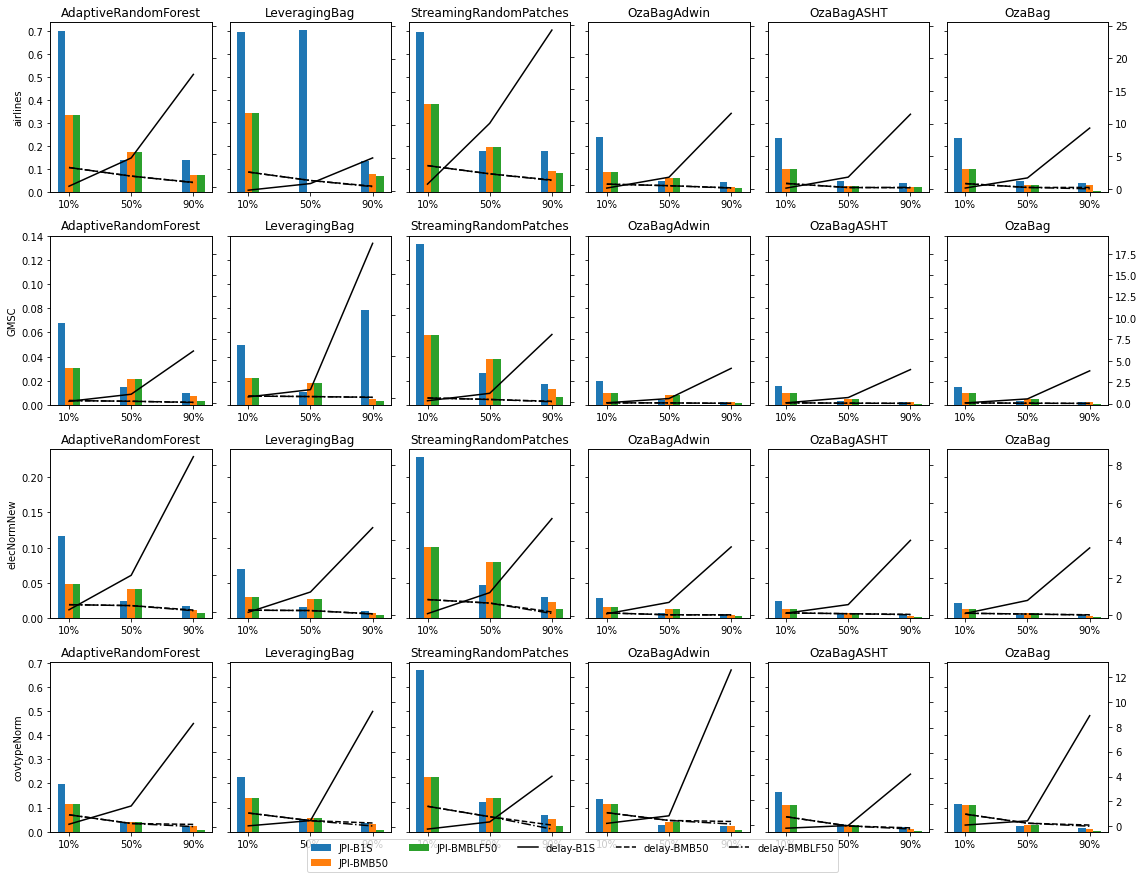

In [1266]:
# freqs = [{}]
dataframes = []
dataframes.append(read_data_create_final_dataframe("", True))

df = dataframes[0]

print(f'\n\n\n----------------- Energy Consume -----------------')
df = select_columns_and_rename_values_basic(df)
gen_graph(df, bars=True, freq=f"")

Grafico JPI X Delay

# Compare Accuracy and IPS

- The IPS has some ligation when accuracy?
- IPS is minor when is frequency is minimum?
- IPS is major when is frequency is maximum?
- IPS is major when utilized mini-batching?

In [1267]:
def plot(ax, dsdf, my_id, x):
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}

    c1 = 'tab:red'
    c2 = 'tab:blue'
    c3 = 'tab:green'
    ds = list(dsdf.dataset)[0]
    ax.set_title(f'{dsformalname[ds]}')
    ax.plot(x, pd.to_numeric(dsdf.acc), color=c1, label='Acuraccy')
    ax.tick_params(axis='y', labelcolor=c1)
    ax.set_xticks(x)
    ax.set_xticklabels(dsdf.methodology_x)
    ax.set_ylim(0,100)
    ax2 = ax.twinx()
    ax2.plot(x, pd.to_numeric(dsdf.IPS), color=c2, label='IPS')
    ax2.tick_params(axis='y', labelcolor=c2)
    ax3 = ax.twinx()
    ax3.plot(x, pd.to_numeric(dsdf.JPI), color=c3, label='JPI')
    ax3.tick_params(axis='y', labelcolor=c3)
    ax3.spines["right"].set_position(("axes", 1.14))
    ax3.set_label('JPI')
    if int(my_id/2) == 1:
        ax.legend(loc='upper center', bbox_to_anchor=(0, -0.20), fancybox=True, shadow=True, ncol=5)
        ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fancybox=True, shadow=True, ncol=5)
        ax3.legend(loc='upper center', bbox_to_anchor=(1, -0.20), fancybox=True, shadow=True, ncol=5)

In [1268]:
def new_plot(ax, dsdf, my_id, x, fig):
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype', 'kyoto_binary': 'Kyoto'}
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm', 'kyoto_binary']
    global twin1
    global twin2
    c1 = 'tab:red'
    c2 = 'tab:blue'
    c3 = 'tab:green'
    ds = list(dsdf.dataset)[0]
    ax.set_title(f'{dsformalname[ds]}')
    ax.plot(x, pd.to_numeric(dsdf.acc), color=c1, label='Acuraccy')
    ax.tick_params(axis='y', labelcolor=c1)
    ax.set_xticks(x)
    ax.set_xticklabels(dsdf.batch_size)
    ax.set_ylim(0,100)
    ax2 = ax.twinx()
    ax2.plot(x, pd.to_numeric(dsdf.IPS), color=c2, label='IPS')
    ax2.tick_params(axis='y', labelcolor=c2)
    ax3 = ax.twinx()
    ax3.plot(x, pd.to_numeric(dsdf.JPI), color=c3, label='JPI')
    ax3.tick_params(axis='y', labelcolor=c3)
    ax3.spines["right"].set_position(("axes", 1.14))
    ax3.set_label('JPI')
    if int(my_id/2) == 1:
        ax.legend(loc='upper center', bbox_to_anchor=(0, -0.20), fancybox=True, shadow=True, ncol=5)
        ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fancybox=True, shadow=True, ncol=5)
        ax3.legend(loc='upper center', bbox_to_anchor=(1, -0.20), fancybox=True, shadow=True, ncol=5)


In [1269]:
def gen_graph_initial_peralg_joules(df, display_df=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    algorithms = ['LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    alg_formal_name = {'ARF': 'AdaptiveRandomForest', 'LBag': 'LeveragingBag', 'SRP':'StreamingRandomPatches', 
                                                'OBAdwin':'OzaBagAdwin', 'OBASHT':'OzaBagASHT', 'OB':'OzaBag'}
    global twin1
    global twin2
    if display_df:
        display(df)
    df = select_columns_and_rename_values(df)
    if display_df:
        display(df)
    for alg in algorithms:
        filename = f"{alg}-sizeVS3"
        fig, axs = plt.subplots(3, 2, figsize=(10,8))
        twin1 = twin2 = axs[0][0]
        axs[2][1].set_visible(False)
        dfalg = filter_by_substring_algorithm(df, alg)
        if display_df:
            display(dfalg)
#         fig.suptitle(f'{alg_formal_name[alg]}')
        for ds in datasets:
#             display(dfalg)
            dsdf = dfalg[(dfalg.dataset == ds)]
            x = np.arange(len(dsdf.ensemble_size))
            if display_df:
                if alg == 'SRP':
                    display(dsdf)
            my_id = datasets.index(ds)
            if my_id == 4:
                pass
            ax = axs[int(my_id/2)][my_id%2]
            new_plot(ax, dsdf, my_id, x, fig)

        fig.tight_layout(pad=0.5)
#         print('pos:', axs[2][0].get_position(), '\nanchor:',axs[2][0].get_anchor())
        x0=0.05081018518518519
        y0=0.03703703703703709
        x1=0.4019981060606061
        y1=0.28742283950617287
        axs[2][0].set_position([x0+0.25, y0, x1-x0, y1-y0])
#         plt.savefig(f'{filename}.eps', bbox_inches='tight')
        
        
        lines_1, labels_1 = axs[0][0].get_legend_handles_labels()
        lines_2, labels_2 = twin1.get_legend_handles_labels()
        lines_3, labels_3 = twin2.get_legend_handles_labels()
        lines = lines_1 + lines_2 + lines_3
        labels = labels_1 + labels_2 + labels_3
        lgd = fig.legend(lines, labels, loc=3, ncol=1, bbox_to_anchor=(0.05, 0.1), prop={'size': 14})
#         lgd.set_in_layout(True)
#         fig.subplots_adjust(bottom=0.2)
        
        plt.savefig(f'Pi-{filename}.eps', pad_inches=1.5)
        print(filename)
        plt.savefig(f'Pi-{filename}.png', pad_inches=1.5)

In [1270]:
def gen_graph_initial_peralg(df, display_df=False, freq=''):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']

    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    filename = f"pi-rates"
    for alg in algorithms:
        fig, axs = plt.subplots(2, 2, figsize=(14,9))
        # set the spacing between subplots
        plt.subplots_adjust(left=0.1,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.9, 
                            wspace=0.4, 
                            hspace=0.4)
        dfalg = filter_by_substring_algorithm(df, alg)
        fig.suptitle(f'{alg} - JPI x IPS x Accuracy')
        for ds in datasets:
            dsdf = dfalg[(dfalg.dataset == ds)]
            x = np.arange(len(dsdf.batch_size))
            my_id = datasets.index(ds)
            ax = axs[int(my_id/2)][my_id%2]
            display(dsdf)
            plot(ax, dsdf, my_id, x)

        plt.savefig(f'{filename}.eps', bbox_inches='tight')

In [1271]:
def build_and_output_graph(execution='first'):
    dataframes = []
    dataframes.append(read_data_create_final_dataframe("", True))

    df = dataframes[0]
    df = df[df.PERC == '90']

    df = df.loc[:,['dataset','algorithm','batch_size', 'instances', 'time', 'JPI', 'acc', 'methodology_x']].sort_values(by=['batch_size', 'methodology_x'])
    df = select_columns_and_rename_values(df)
    df['IPS'] = df['instances'] / df['time']
    df['ensemble_size'] = '25'

    df.methodology_x[df.methodology_x == 1] = 'Sequential'
    df.methodology_x[df.methodology_x == 2] = 'MB-4'
    df.methodology_x[df.methodology_x == 3] = 'MB+LF-4' 

    gen_graph_initial_peralg(df, display_df=False)

# Acuracia, IPS e JPI 

Nesta seção analisaremos os resultados entre 3 variáveis, que são a acuracia, o IPS e o JPI. Estes tres resultados permitem que possamos ver com uma melhor percepção o real ganho da implementação do loop fusion e também qual é o melhor tamanho de mini-batching para essa implementação. 

Primeiro, algumas considerações existem algumas execuções duplicadas no mini-batching o que ocasiona que sempre no proximo tamanho de mini-batching do eixo x ele faz uma soma do tamanho anterior o que da um gráfico meio estranho. Dito isso, podemos desconsiderar a informação e verificar os dados corretamente.

Todos os algoritmos e datasets apresentam esse comportamento. 

moaDF: 216    mdf: 216     sshDF: 216


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_9489/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_9489/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_9489/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_9489/3478987594.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential"

,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
136,airlines,ARFSequential,1,"3,576.00",120.01,0.14,70.02,Sequential,29.80,25
28,airlines,ARFMB,50,"8,400.00",120.26,0.07,65.84,MB-4,69.85,25
209,airlines,ARFMB,50,"9,600.00",122.18,0.07,64.93,MB+LF-4,78.57,25


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
111,GMSC,ARFSequential,1,"48,257.00",120.00,0.01,93.44,Sequential,402.14,25
107,GMSC,ARFMB,50,"69,484.00",119.98,0.01,93.50,MB-4,579.13,25
29,GMSC,ARFMB,50,"150,000.00",98.70,0.00,93.53,MB+LF-4,"1,519.80",25


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
31,elecNormNew,ARFSequential,1,"28,168.00",120.00,0.02,89.13,Sequential,234.73,25
200,elecNormNew,ARFMB,50,"45,312.00",114.93,0.01,80.23,MB-4,394.25,25
78,elecNormNew,ARFMB,50,"43,000.00",55.10,0.01,88.92,MB+LF-4,780.43,25


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
100,covtypeNorm,ARFSequential,1,"19,328.00",120.00,0.03,77.11,Sequential,161.06,25
66,covtypeNorm,ARFMB,50,"18,569.00",119.89,0.03,71.86,MB-4,154.88,25
167,covtypeNorm,ARFMB,50,"103,550.00",119.97,0.01,90.64,MB+LF-4,863.13,25


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
138,airlines,LBagSequential,1,"3,793.00",120.00,0.13,68.55,Sequential,31.61,25
41,airlines,LBagMB,50,"7,800.00",120.42,0.08,62.85,MB-4,64.77,25
142,airlines,LBagMB,50,"9,800.00",121.69,0.07,61.77,MB+LF-4,80.54,25


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
22,GMSC,LBagSequential,1,"6,602.00",120.02,0.08,93.56,Sequential,55.01,25
183,GMSC,LBagMB,50,"97,550.00",120.02,0.01,93.34,MB-4,812.76,25
210,GMSC,LBagMB,50,"145,900.00",82.16,0.00,93.37,MB+LF-4,"1,775.74",25


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
152,elecNormNew,LBagSequential,1,"42,498.00",100.33,0.01,89.55,Sequential,423.57,25
215,elecNormNew,LBagMB,50,"45,312.00",75.70,0.01,81.41,MB-4,598.60,25
178,elecNormNew,LBagMB,50,"42,050.00",38.45,0.01,90.51,MB+LF-4,"1,093.74",25


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
16,covtypeNorm,LBagSequential,1,"12,909.00",120.00,0.04,74.31,Sequential,107.57,25
91,covtypeNorm,LBagMB,50,"15,574.00",119.98,0.03,70.26,MB-4,129.81,25
130,covtypeNorm,LBagMB,50,"71,050.00",120.01,0.01,90.37,MB+LF-4,592.03,25


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
51,airlines,SRPSequential,1,"2,729.00",120.04,0.18,73.29,Sequential,22.73,25
134,airlines,SRPMB,50,"7,700.00",120.18,0.09,66.08,MB-4,64.07,25
207,airlines,SRPMB,50,"8,600.00",120.23,0.08,65.51,MB+LF-4,71.53,25


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
154,GMSC,SRPSequential,1,"28,092.00",120.00,0.02,93.55,Sequential,234.10,25
19,GMSC,SRPMB,50,"37,737.00",119.93,0.01,93.55,MB-4,314.65,25
193,GMSC,SRPMB,50,"101,450.00",120.08,0.01,93.46,MB+LF-4,844.84,25


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
150,elecNormNew,SRPSequential,1,"16,550.00",120.01,0.03,91.38,Sequential,137.90,25
170,elecNormNew,SRPMB,50,"23,361.00",119.92,0.02,82.76,MB-4,194.81,25
1,elecNormNew,SRPMB,50,"45,100.00",115.29,0.01,89.56,MB+LF-4,391.19,25


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
109,covtypeNorm,SRPSequential,1,"7,161.00",120.01,0.07,82.15,Sequential,59.67,25
4,covtypeNorm,SRPMB,50,"8,986.00",120.00,0.05,77.10,MB-4,74.88,25
172,covtypeNorm,SRPMB,50,"27,550.00",119.99,0.02,87.65,MB+LF-4,229.59,25


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
95,airlines,OBAdwinSequential,1,"12,182.00",120.01,0.04,63.80,Sequential,101.50,25
5,airlines,OBAdwinMB,50,"26,356.00",119.98,0.02,67.32,MB-4,219.67,25
20,airlines,OBAdwinMB,50,"42,000.00",120.23,0.02,86.54,MB+LF-4,349.34,25


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
7,GMSC,OBAdwinSequential,1,"145,472.00",102.23,0.00,93.45,Sequential,"1,422.95",25
45,GMSC,OBAdwinMB,50,"150,000.00",85.11,0.00,93.35,MB-4,"1,762.51",25
157,GMSC,OBAdwinMB,50,"148,900.00",41.45,0.00,93.45,MB+LF-4,"3,591.93",25


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
171,elecNormNew,OBAdwinSequential,1,"39,257.00",49.89,0.01,84.15,Sequential,786.89,25
94,elecNormNew,OBAdwinMB,50,"45,312.00",42.23,0.00,79.97,MB-4,"1,072.88",25
169,elecNormNew,OBAdwinMB,50,"42,950.00",20.11,0.00,85.64,MB+LF-4,"2,135.43",25


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
52,covtypeNorm,OBAdwinSequential,1,"19,872.00",120.00,0.02,74.92,Sequential,165.60,25
48,covtypeNorm,OBAdwinMB,50,"18,569.00",119.93,0.03,70.50,MB-4,154.83,25
156,covtypeNorm,OBAdwinMB,50,"105,350.00",120.00,0.01,87.63,MB+LF-4,877.91,25


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
164,airlines,OBASHTSequential,1,"12,420.00",120.71,0.04,63.80,Sequential,102.89,25
205,airlines,OBASHTMB,50,"33,950.00",121.17,0.02,65.03,MB-4,280.18,25
63,airlines,OBASHTMB,50,"25,000.00",120.77,0.02,56.25,MB+LF-4,207.01,25


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
113,GMSC,OBASHTSequential,1,"144,090.00",80.93,0.00,93.33,Sequential,"1,780.54",25
6,GMSC,OBASHTMB,50,"150,000.00",81.70,0.00,93.39,MB-4,"1,835.94",25
92,GMSC,OBASHTMB,50,"142,850.00",24.63,0.00,93.40,MB+LF-4,"5,800.31",25


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
129,elecNormNew,OBASHTSequential,1,"38,362.00",43.31,0.01,82.90,Sequential,885.77,25
128,elecNormNew,OBASHTMB,50,"45,312.00",34.79,0.00,79.57,MB-4,"1,302.56",25
140,elecNormNew,OBASHTMB,50,"43,500.00",12.19,0.00,77.77,MB+LF-4,"3,568.21",25


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
10,covtypeNorm,OBASHTSequential,1,"23,830.00",120.00,0.02,71.69,Sequential,198.58,25
195,covtypeNorm,OBASHTMB,50,"286,750.00",120.00,0.00,78.43,MB+LF-4,"2,389.56",25
165,covtypeNorm,OBASHTMB,50,"32,300.00",119.91,0.01,69.80,MB+LF-4,269.37,25


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
187,airlines,OBSequential,1,"12,357.00",120.01,0.04,63.65,Sequential,102.97,25
125,airlines,OBMB,50,"25,450.00",121.52,0.03,63.90,MB-4,209.43,25
155,airlines,OBMB,50,"190,000.00",120.01,0.00,62.62,MB+LF-4,"1,583.18",25


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
141,GMSC,OBSequential,1,"143,472.00",79.36,0.00,93.46,Sequential,"1,807.93",25
15,GMSC,OBMB,50,"150,000.00",81.68,0.00,93.48,MB-4,"1,836.52",25
116,GMSC,OBMB,50,"142,800.00",23.93,0.00,93.47,MB+LF-4,"5,968.40",25


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
214,elecNormNew,OBSequential,1,"37,864.00",39.36,0.00,82.36,Sequential,962.09,25
204,elecNormNew,OBMB,50,"45,312.00",35.63,0.00,78.68,MB-4,"1,271.70",25
146,elecNormNew,OBMB,50,"43,150.00",12.18,0.00,77.36,MB+LF-4,"3,542.11",25


,dataset,algorithm,batch_size,instances,time,JPI,acc,methodology_x,IPS,ensemble_size
108,covtypeNorm,OBSequential,1,"27,907.00",120.00,0.02,71.97,Sequential,232.56,25
143,covtypeNorm,OBMB,50,"283,750.00",120.00,0.00,80.47,MB+LF-4,"2,364.56",25
9,covtypeNorm,OBMB,50,"31,700.00",119.89,0.01,68.23,MB+LF-4,264.40,25


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


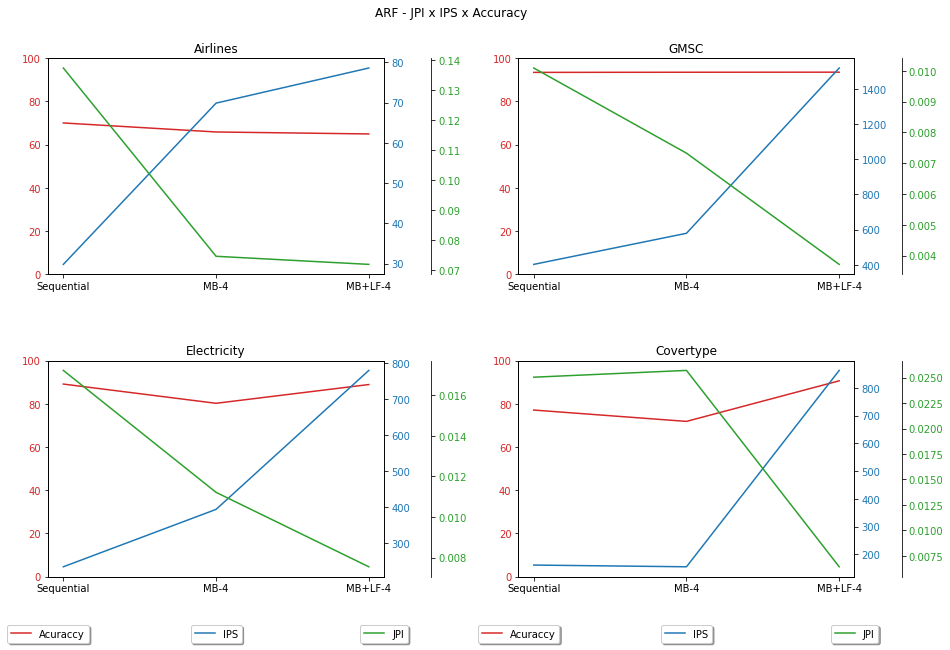

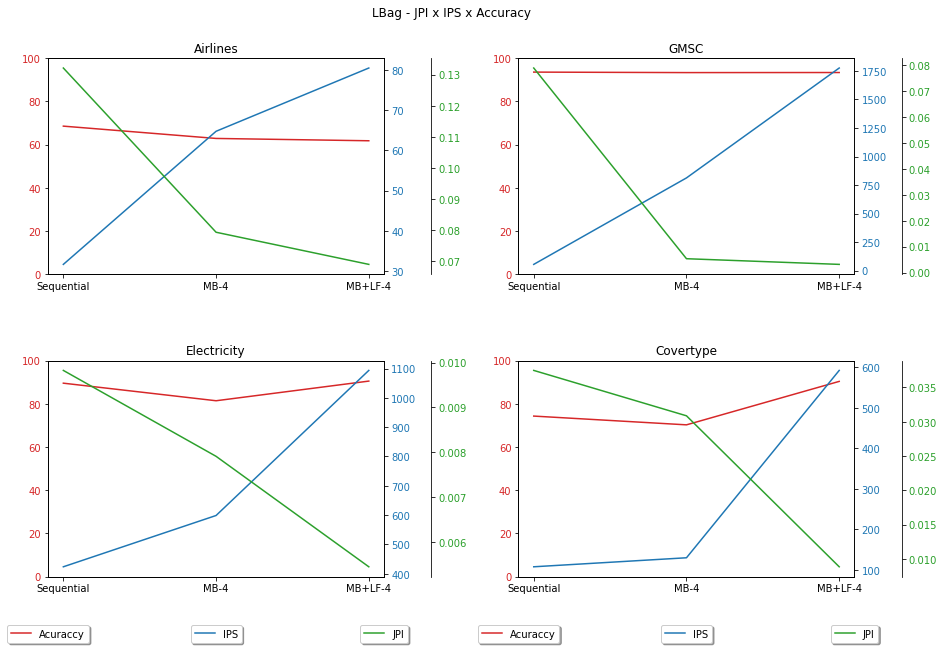

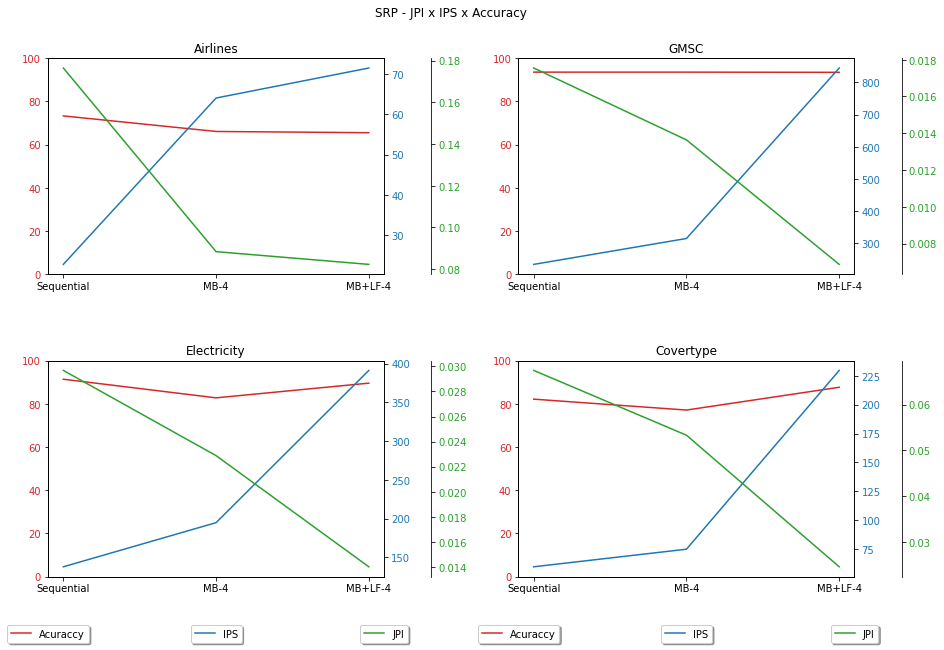

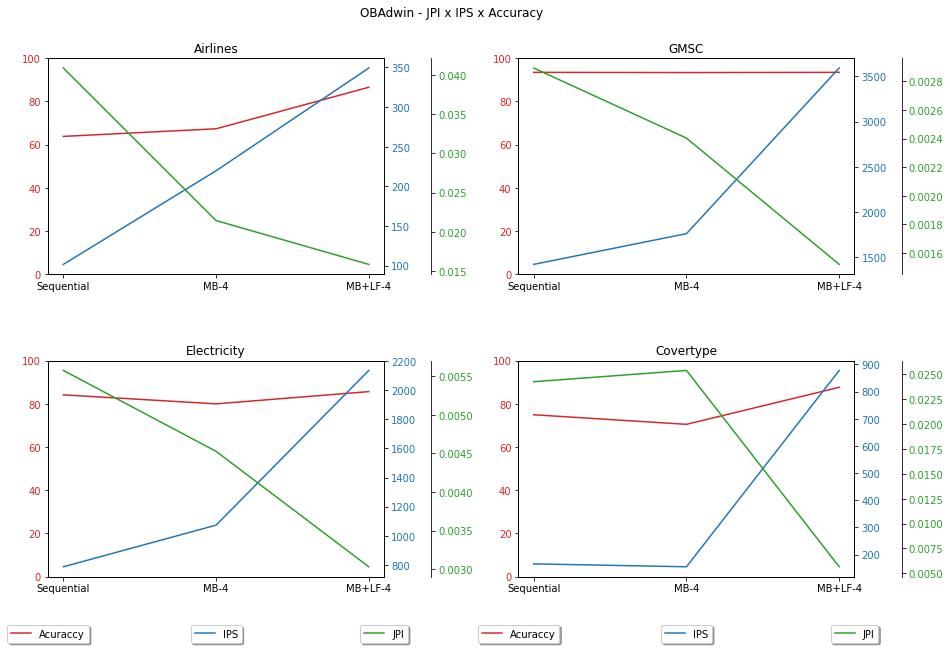

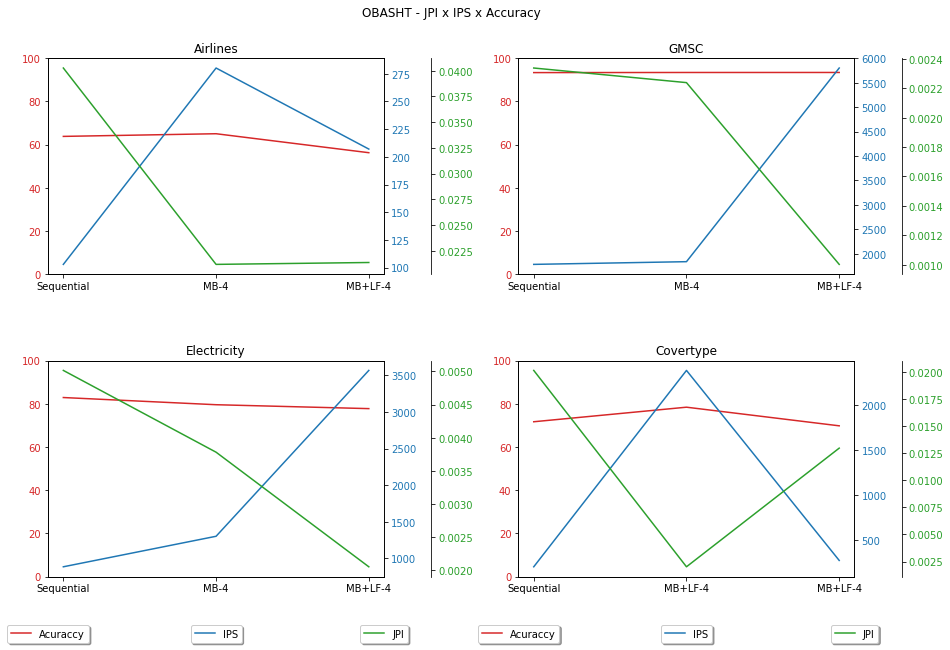

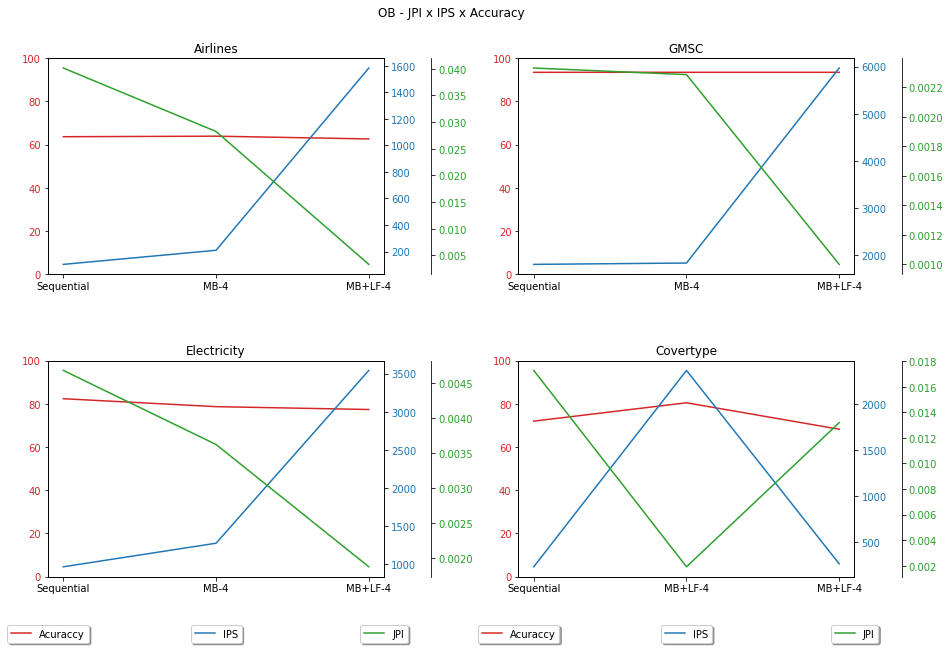

In [1272]:
build_and_output_graph()